In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
#Task 1 - Part 1
def clean_data(df):
    #Takes in a pyspark dataframe
    #Counts number of entries before and after dropping duplicates,
    #nulls and missing values.
    print(f'Original count {df.count()}')
    df = df.dropDuplicates()
    df = df.dropna()
    print(f'New count {df.count()}')
    return df

df = spark.read.csv('nuclear_plants_small_dataset.csv',inferSchema=True,header=True)
df = clean_data(df)

Original count 996
New count 996


Normal group summary statistics:
  Statistic Power_range_sensor_1 Power_range_sensor_2 Power_range_sensor_3   \
0      mean    5.602452811244987    6.844503413654614     9.292054016064252   
1       min               0.0851               0.0403                4.3826   
2       max              12.1298              11.9284               14.0982   
3       50%               5.1727               6.6998                9.2624   

  Power_range_sensor_4   Pressure_sensor_1   Pressure_sensor_2  \
0    8.701398192771098  13.797525502008027  3.4156463855421686   
1               0.1547              0.0248              0.0104   
2              16.3568             56.8562              9.2212   
3               9.2404             10.6274               3.113   

   Pressure_sensor_3  Pressure_sensor_4 Vibration_sensor_1 Vibration_sensor_2  \
0  5.923352610441763  5.586180120481918  8.441436947791164  9.699615863453817   
1             0.0774             0.0058             0.0092             0.0277 

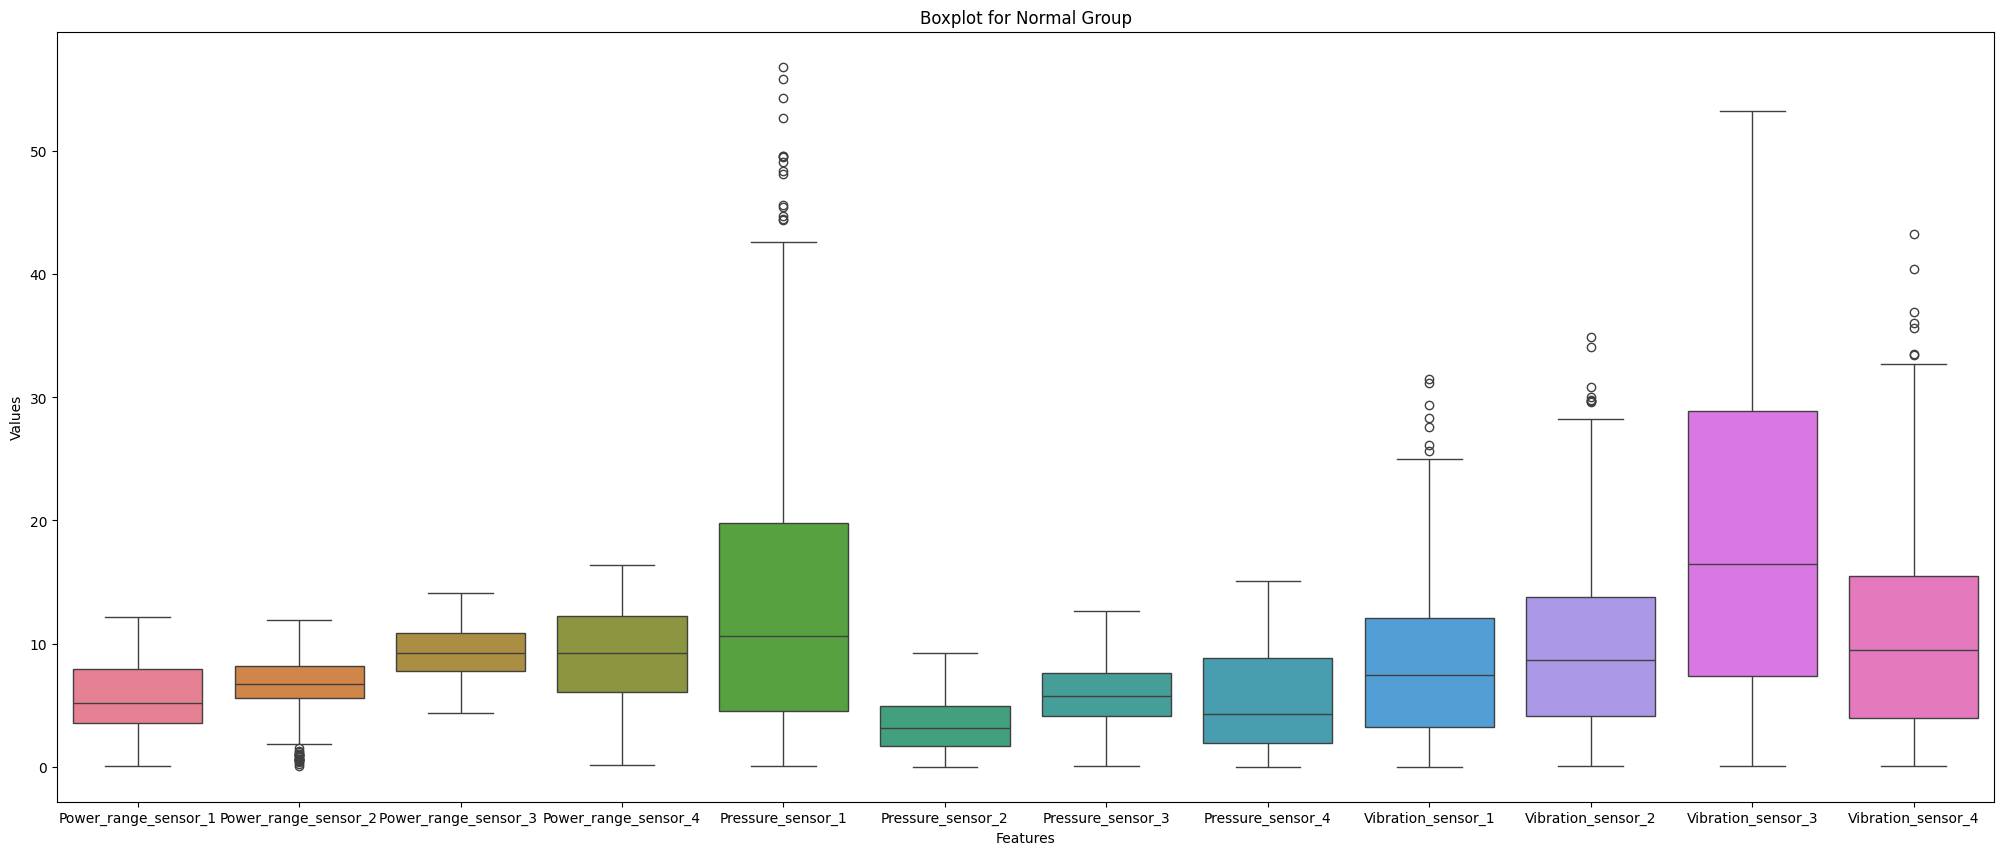

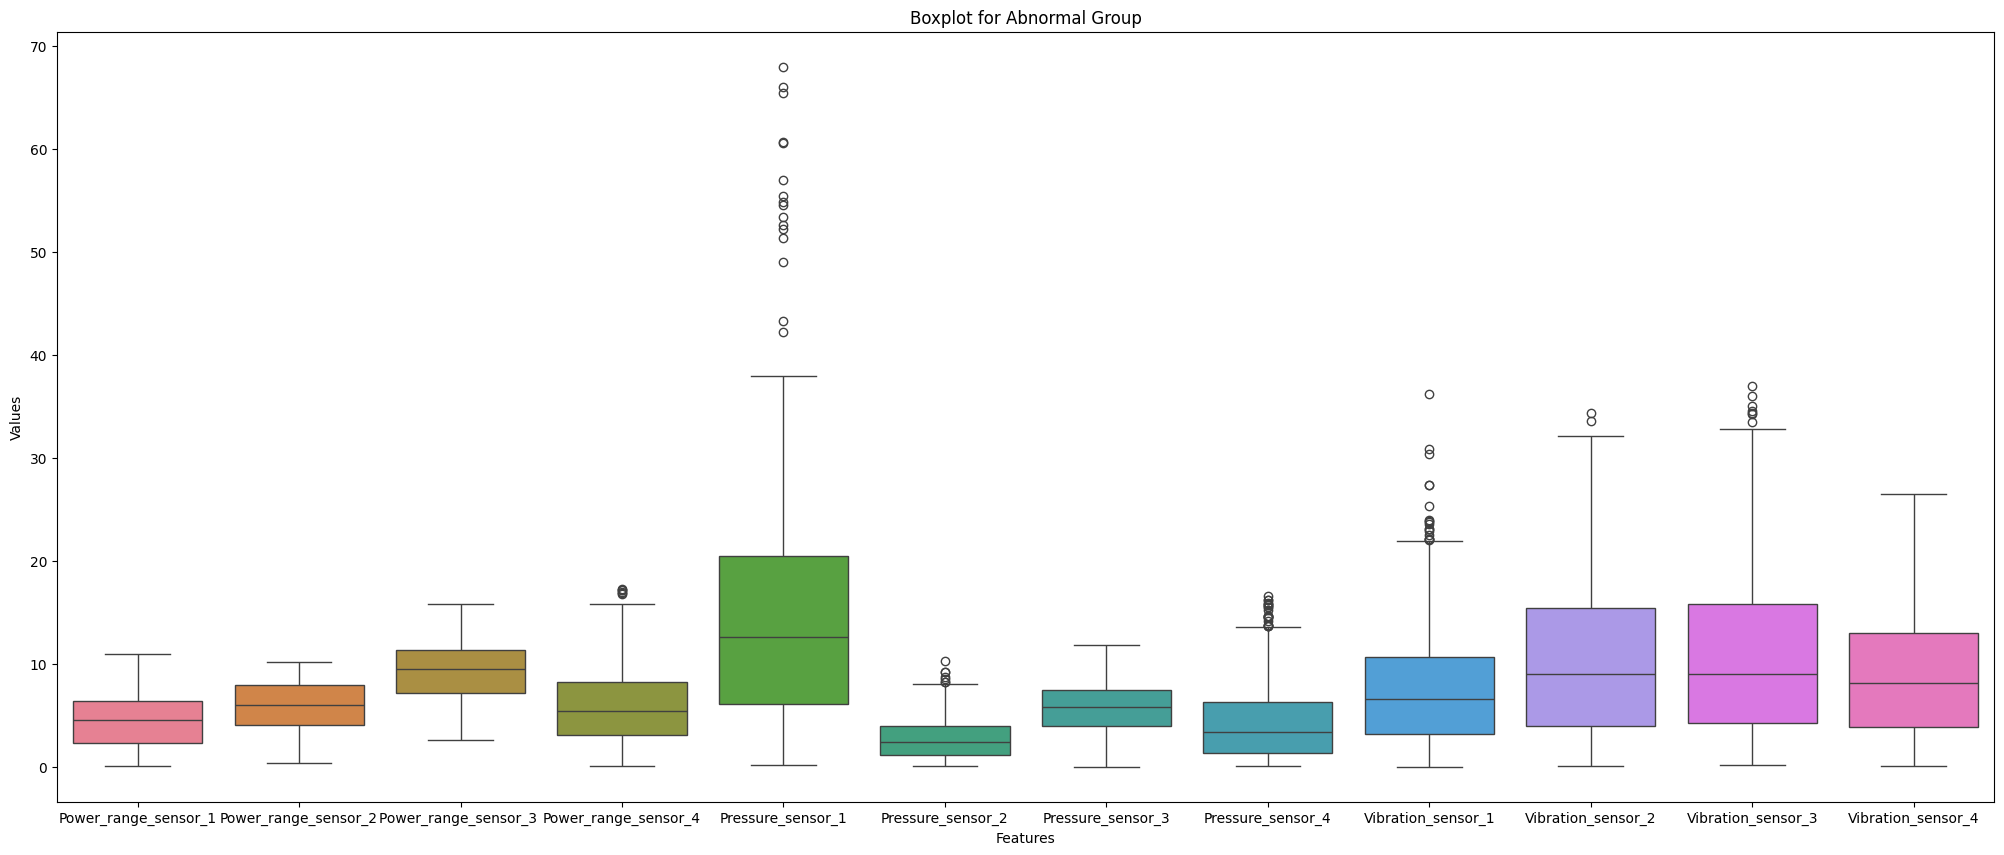

<Axes: title={'center': 'Correlation Matrix of Features for All Groups'}>

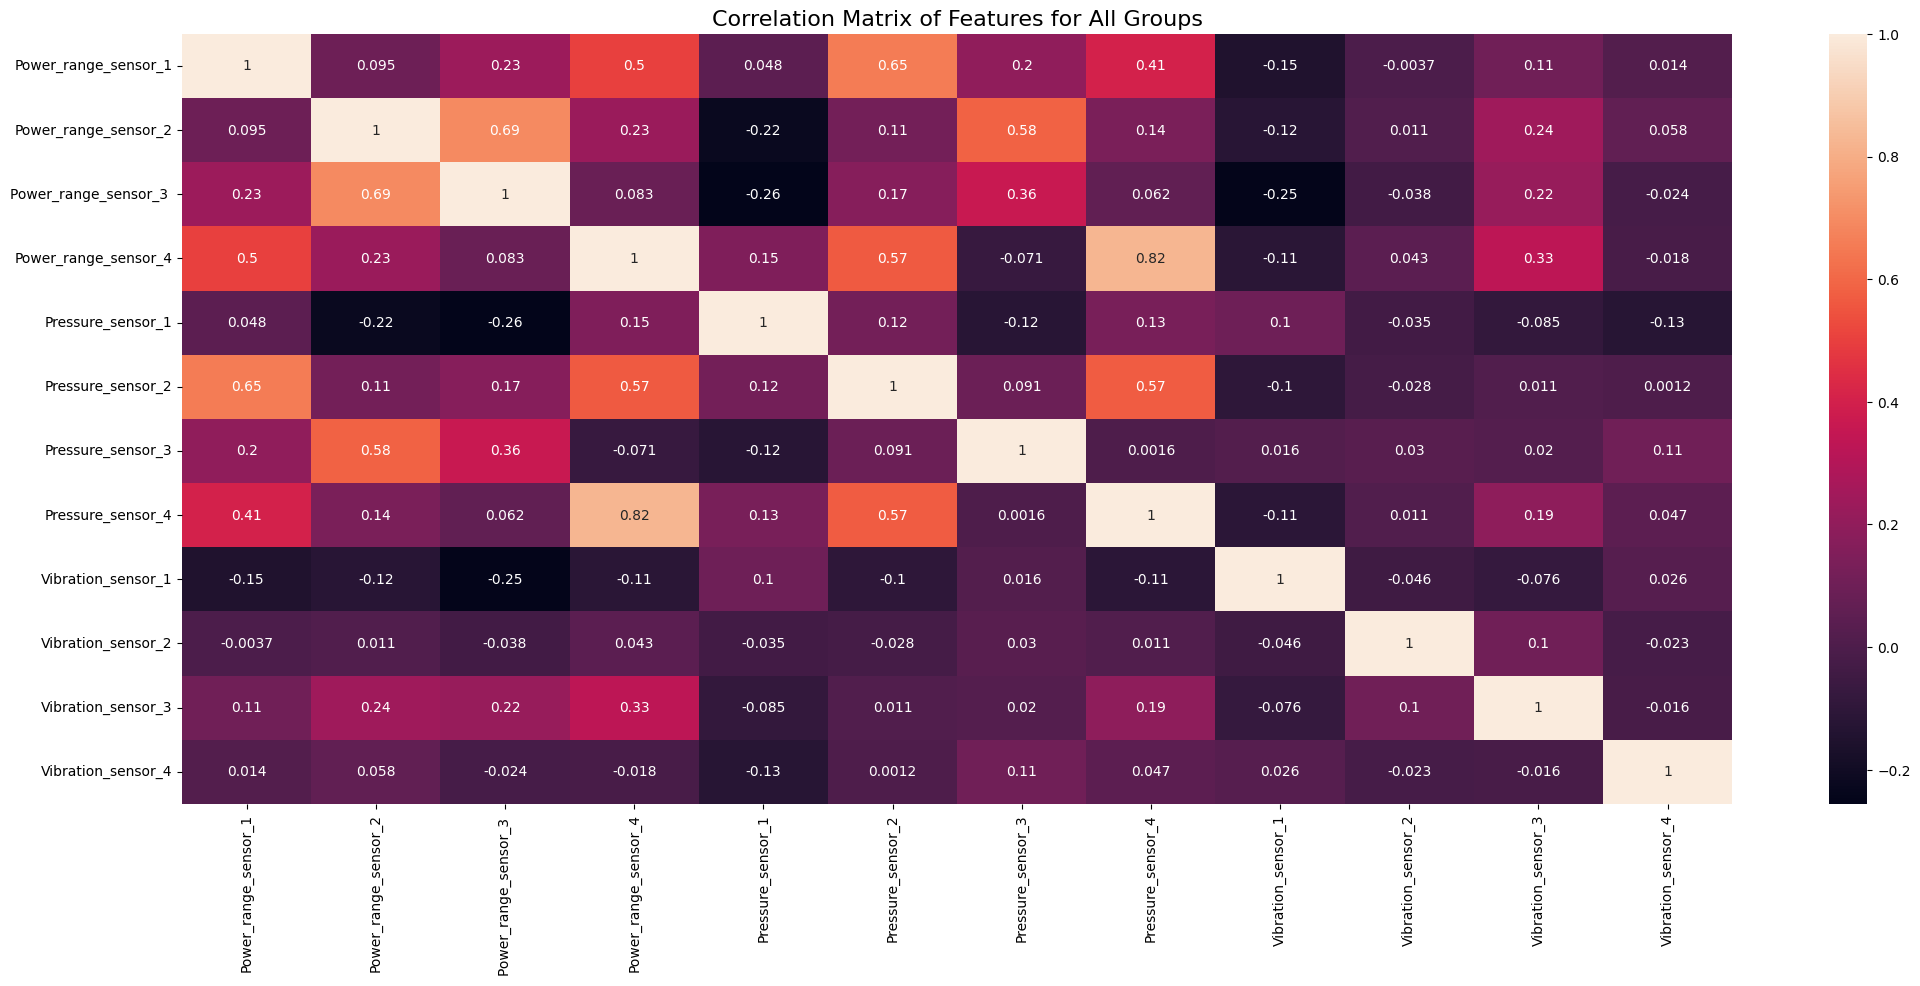

In [5]:
#Task 1 - Part 2 and 3

def filter_df(df):
    #Filters dataframe by normal and abnormal groups
    #Returns two dataframes, one for each group.
    normal_df = df.filter(df['Status'] == 'Normal')
    abnormal_df = df.filter(df['Status'] == 'Abnormal')

    return normal_df, abnormal_df


def summary_stats(df):
    #Takes in pyspark dataframe
    #Drops the status column and uses .summary to find mean min max and median, renames the 50% to median
    #Then converts to a pandas dataframe.
    
    normal_df, abnormal_df = filter_df(df)


    dfSummaryNormal = normal_df.drop('Status').summary('mean','min','max','50%')
    dfSummaryNormal = dfSummaryNormal.withColumnRenamed("50%","median")\
                            .withColumnRenamed('summary', 'Statistic')
    
    dfSummaryAbnormal = abnormal_df.drop('Status').summary('mean','min','max','50%')
    dfSummaryAbnormal = dfSummaryAbnormal.withColumnRenamed("50%","median")\
                            .withColumnRenamed('summary', 'Statistic')
    
    return dfSummaryNormal, dfSummaryAbnormal


def boxplot_df(df):
    #Takes in pyspark dataframe filters to normal and abnormal groups, converts to pandas dataframe
    #and plots a boxplot for each feature in each group.

    #Filter the dataframe by normal and abnormal groups
    normal_df, abnormal_df = filter_df(df)

    if normal_df:
        normal_df = normal_df.toPandas()
        #Drop the status column
        normal_df.drop('Status',axis=1,inplace=True)
        plt.figure(figsize=(25,10))
        sns.boxplot(data=normal_df)
        plt.ylabel('Values')
        plt.xlabel('Features')
        plt.title('Boxplot for Normal Group')
        plt.show()
    if abnormal_df:
        abnormal_df = abnormal_df.toPandas()
        #Drop the status column
        abnormal_df.drop('Status',axis=1,inplace=True)
        plt.figure(figsize=(25,10))
        sns.boxplot(data=abnormal_df)
        plt.ylabel('Values')
        plt.xlabel('Features')
        plt.title('Boxplot for Abnormal Group')
        plt.show()

summaryNormal, summaryAbnormal = summary_stats(df)
print('Normal group summary statistics:')
summaryNormal = summaryNormal.toPandas()
print(summaryNormal)
#summaryNormal.show()

print('Abnormal group summary statistics:')
summaryAbnormal = summaryAbnormal.toPandas()
print(summaryAbnormal)
#summaryAbnormal.show()

boxplot_df(df)

#Correlation Matrix creation and show
df = df.drop('Status').toPandas()
df_corr = df.corr()

plt.figure(figsize=(25,10))
plt.title('Correlation Matrix of Features for All Groups',y=1,size=16)
sns.heatmap(df_corr,annot = True)

In [6]:
#Task 2 - Map Reduce
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
#Task 2 - Part 1

airport_names = spark.read.csv('Top30_airports_LatLong.csv',inferSchema=True,)
airport_names = airport_names.withColumnRenamed('_c0','airportName')\
        .withColumnRenamed('_c1','Code')\
        .withColumnRenamed('_c2','Latitude')\
        .withColumnRenamed('_c3','Longitude')

passenger_data = spark.read.csv('AComp_Passenger_data_no_error.csv',inferSchema=True)
passenger_data = passenger_data.withColumnRenamed('_c0','passengerID')\
        .withColumnRenamed('_c1','flightID')\
        .withColumnRenamed('_c2','Origin_Code')\
        .withColumnRenamed('_c3','Destination_Code')\
        .withColumnRenamed('_c4','departureTime_GMT')\
        .withColumnRenamed('_c5','totalFlightTime_mins')

#join the airport names to the passenger data
passenger_data = passenger_data.join(airport_names,passenger_data.Origin_Code == airport_names.Code)


#Count the number of flights from each airport
passenger_data_rdd = sc.parallelize(passenger_data.collect(), 1)
passenger_data_flights = passenger_data_rdd.map(lambda x: (x[6],1))
passenger_data_flights = passenger_data_flights.reduceByKey(lambda x,y: x+y)
passenger_data_flights = passenger_data_flights.sortBy(lambda x: x[1],ascending=False)
passenger_data_flights = passenger_data_flights.collect()
passenger_data_df = pd.DataFrame(passenger_data_flights,columns=['Airport Name','Number of Flights'])

In [7]:
print('Number of flights from each airport:')
print(passenger_data_df)

Number of flights from each airport:
         Airport Name  Number of Flights
0              DENVER                 46
1           GUANGZHOU                 37
2             HOUSTON                 37
3             ATLANTA                 36
4             CHICAGO                 33
5        KUALA LUMPUR                 33
6             JAKARTA                 27
7            NEW YORK                 25
8              LONDON                 25
9               PARIS                 21
10          CHARLOTTE                 21
11           SHANGHAI                 20
12          LAS VEGAS                 17
13            BANGKOK                 17
14          AMSTERDAM                 15
15               ROME                 15
16             MUNICH                 14
17             MADRID                 13
18            BEIJING                 13
19              TOKYO                 13
20  DALLAS/FORT WORTH                 11
21              MIAMI                 11


In [8]:
#Create a list of unused airports using mapreduce
# Parallelize and partition the dataset 
# so that the partitions can be operated
# upon via multiple worker processes.
airport_rdd = sc.parallelize(airport_names.collect(), 1)
# Extract the airport codes from the passenger data ensuring to check origin and destination codes.
used_airports = passenger_data_rdd.flatMap(lambda x: [x[2], x[3]]).distinct()

# Extract all airport codes from the airport data
all_airports = airport_rdd.map(lambda x: x[1])

# Find unused airports using the subtract operation
unused_airports = all_airports.subtract(used_airports)

# Collect the result turn into pandas dataframe
unused_airports = unused_airports.collect()
unused_airports_df = pd.DataFrame(unused_airports,columns=['Unused Airports'])


In [9]:
#Unused airports
print(unused_airports_df)

  Unused Airports
0             PHX
1             IST


In [10]:
#Task 2 - Part 2
#Create a list of flights based on the Flight id; including number of passengers, relevant IATA/FAA 
#codes, and departure and arrival times (times converted to HH:MM format) 


passenger_count = passenger_data.groupBy("flightId", "Origin_Code", "Destination_Code").agg(
        F.count("PassengerId").alias("PassengerCount"),
        F.first("departureTime_GMT").alias("departureTime_GMT"),
        F.first("totalFlightTime_mins").alias("totalFlightTime_sec")
)
#calculate the arrival time 
passenger_count = passenger_count.withColumn("arrivalTime_GMT", F.col("departureTime_GMT") + F.col("totalFlightTime_sec")*60)
#convert arrival time to HH:MM format
passenger_count = passenger_count.withColumn("arrivalTime_GMT", F.from_unixtime("arrivalTime_GMT", "HH:mm"))
passenger_count = passenger_count.withColumn("departureTime_GMT", F.from_unixtime("departureTime_GMT", "HH:mm"))
passenger_count = passenger_count.drop("totalFlightTime_sec")
passenger_count.show()

+--------+-----------+----------------+--------------+-----------------+---------------+
|flightId|Origin_Code|Destination_Code|PassengerCount|departureTime_GMT|arrivalTime_GMT|
+--------+-----------+----------------+--------------+-----------------+---------------+
|EWH6301Y|        CAN|             DFW|            10|            17:22|          21:25|
|FYL5866L|        ATL|             HKG|            20|            17:25|          22:36|
|RPG3351U|        HND|             CAN|            13|            16:59|          23:13|
|WSK1289Z|        CLT|             DEN|            21|            16:59|          21:37|
|XOY7948U|        ATL|             LHR|            16|            17:07|          07:44|
|ULZ8130D|        CAN|             DFW|            27|            17:23|          21:26|
|KJR6646J|        IAH|             BKK|            23|            17:26|          01:34|
|XXQ4064B|        JFK|             FRA|            25|            17:05|          06:27|
|BER7172M|        KUL

In [11]:
#Task 2 - Part 2
#Create a list of flights based on the Flight id; including number of passengers, relevant IATA/FAA
#codes, and departure and arrival times (times converted to HH:MM format)
flight_list_rdd = passenger_data_rdd.map(lambda x: ((x[1],x[2],x[3],x[4],x[5]), 1))
flight_list_rdd = flight_list_rdd.reduceByKey(lambda x,y: x+y)


from datetime import datetime
# Converts Unix Epoch time to HH:MM.
def unix_to_GMT(unixtime): 
    GMT = datetime.fromtimestamp(unixtime)  
    return GMT.strftime("%H:%M")



list_of_flights_mapped = flight_list_rdd.map(
    lambda x: (x[0][0],x[0][1],x[0][2],
        unix_to_GMT((x[0][3])),
        unix_to_GMT((x[0][3]) + (x[0][4])*60),
        x[1]
    )
)

list_of_flights_mapped_df = pd.DataFrame(list_of_flights_mapped.collect(), columns=['Flight ID', 'Origin', 'Destination', 'Departure Time', 'Arrival Time', 'Passengers'])
print(list_of_flights_mapped_df)


   Flight ID Origin Destination Departure Time Arrival Time  Passengers
0   SQU6245R    DEN         FRA          17:14        10:43          21
1   XXQ4064B    JFK         FRA          17:05        06:27          25
2   SOH3431A    ORD         MIA          17:00        21:10          18
3   PME8178S    DEN         PEK          17:13        15:15          18
4   MBA8071P    KUL         PEK          17:04        02:36          16
5   MOO1786A    MAD         FRA          16:56        20:00          13
6   HUR0974O    DEN         PVG          17:15        16:33           7
7   GMO5938W    LHR         PEK          17:11        10:48          25
8   DAU2617A    CGK         SFO          17:23        23:34          12
9   RUM0422W    MUC         MAD          16:58        20:12          14
10  ATT7791R    AMS         DEN          17:13        09:54          15
11  WPW9201U    DFW         PEK          17:21        17:33          11
12  DKZ3042O    MIA         SFO          17:05        02:03     

In [12]:
#Task 2 - Part 3
# Calculate the line-of-sight (nautical) miles for each flight and the total travelled by each passenger, 
#then output the passenger having earned the highest air miles
from math import radians, cos, sin, atan2, sqrt, pi
airport_names.show()
def nautical_miles(lat1, lon1, lat2, lon2):
    lat1= float(lat1)
    lon1=float(lon1)
    lat2=float(lat2)
    lon2=float(lon2)
    earth_radius = 6371 #in km
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    deltalat = lat2 - lat1
    deltalon = lon2 - lon1
    a = sin(deltalat/2)*sin(deltalat/2)+cos(lat1)*cos(lat2) \
        *sin(deltalon/2)*sin(deltalon/2)
    c = 2*atan2(sqrt(a),sqrt(1-a))
    distance = earth_radius*c
    return distance/1.852 #convert to nautical miles from km


print(airport_rdd.take(1))
#flightid, origin
origin_rdd = passenger_data_rdd.map(lambda x: (x[1],(x[2])))
#flightid, destination
destination_rdd = passenger_data_rdd.map(lambda x: (x[1],(x[3])))
#code, lat, long
airport_map = airport_rdd.map(lambda x: (x[1],(x[2],x[3])))


+-----------------+----+---------+-----------+
|      airportName|Code| Latitude|  Longitude|
+-----------------+----+---------+-----------+
|          ATLANTA| ATL|33.636719| -84.428067|
|          BEIJING| PEK|40.080111| 116.584556|
|           LONDON| LHR|  51.4775|  -0.461389|
|          CHICAGO| ORD|41.978603| -87.904842|
|            TOKYO| HND|35.552258| 139.779694|
|      LOS ANGELES| LAX|33.942536|-118.408075|
|            PARIS| CDG|49.012779|       2.55|
|DALLAS/FORT WORTH| DFW|32.896828| -97.037997|
|        FRANKFURT| FRA|50.026421|   8.543125|
|        HONG KONG| HKG|22.308919| 113.914603|
|           DENVER| DEN|39.861656|-104.673178|
|            DUBAI| DXB|25.252778|  55.364444|
|          JAKARTA| CGK|-6.125567| 106.655897|
|        AMSTERDAM| AMS|52.308613|   4.763889|
|           MADRID| MAD|40.493556|  -3.566764|
|          BANGKOK| BKK|13.681108| 100.747283|
|         NEW YORK| JFK|40.639751| -73.778925|
|        SINGAPORE| SIN| 1.350189| 103.994433|
|        GUAN